In [1]:
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
XDF_FILE = "1_20_26_a.xdf"   # path to your xdf file

# ==========================
# LOAD XDF
# ==========================
streams, header = pyxdf.load_xdf(XDF_FILE)

print(f"Loaded {len(streams)} streams")

# Sort streams by name for consistent ordering
streams = sorted(streams, key=lambda s: s['info']['name'][0])

Stream 3: Calculated effective sampling rate 611.8225 Hz is different from specified rate 1000.0000 Hz.


Loaded 4 streams


611.8224602847541
ECG_Stream: (6118, 1), 1000.0 Hz
24.943347020553386
PPG_GRN: (250, 1), 25.0 Hz
24.94334581128932
PPG_IR: (250, 1), 25.0 Hz
24.943346321230997
PPG_RED: (250, 1), 25.0 Hz


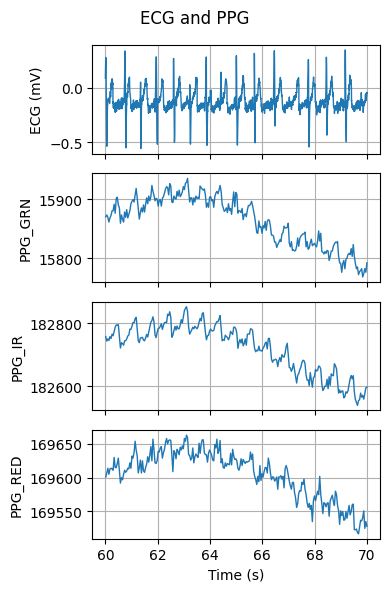

In [3]:
fig, axes = plt.subplots(len(streams), 1, sharex=True, figsize=(4, 6))

if len(streams) == 1:
    axes = [axes]  # handle edge case

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    srate = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]  # normalize to start at 0
    print(1.0 / np.mean(np.diff(timestamps)))
    mask = (60 <= timestamps) & (timestamps <= 70)
    timestamps = timestamps[mask]
    data = data[mask]

    if name == "ECG_Stream":
        # For ECG, convert to mV assuming 12-bit ADC, 3.3V reference and gain of 1100
        data = (((data / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
    
    print(f"{name}: {data.shape}, {srate} Hz")

    # If multichannel, plot first channel (change if needed)
    if data.ndim > 1:
        data = data[:, 0]

    axes[idx].plot(timestamps, data, linewidth=1)
    axes[idx].set_ylabel("ECG (mV)" if name == "ECG_Stream" else name)
    axes[idx].grid(True)

axes[-1].set_xlabel("Time (s)")

plt.suptitle("ECG and PPG")
plt.tight_layout()
plt.show()

In [3]:
import heartpy as hp

def estimate_fs(timestamps):
    diffs = np.diff(timestamps)
    median_diff = np.median(diffs)
    estimated_fs = 1.0 / median_diff
    return estimated_fs

c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\heartpy\datautils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [5]:
import numpy as np
import neurokit2 as nk

def save_for_physiozoo(filename, signal, fs, mammal='human'):
    """
    Saves a 1D signal to a PhysioZoo compatible text file with header.
    """
    header = (
        f"--- Mammal: {mammal}\n"
        f"Fs: {fs}\n"
        f"Integration_Level: electrocardiogram\n"
        f"Channels:\n"
        f"- type: electrography\n"
        f"  name: ECG\n"
        f"  unit: mV\n"
        f"  enable: yes\n"
        f"---\n"
    )
    
    with open(filename, 'w') as f:
        f.write(header)
        # Write the signal values line by line
        np.savetxt(f, signal, fmt='%.4f')
        
def save_for_physiozoo_ppg(filename, signal, fs, mammal='human', channel_name='PPG_Green'):
    """
    Save a 1D PPG signal to a PhysioZoo-compatible .txt file with proper YAML header.
    
    Parameters:
    -----------
    filename : str
        Output file path (e.g. 'my_ppg.txt')
    signal : np.ndarray
        1D array of PPG samples
    fs : float
        Sampling frequency in Hz
    mammal : str, optional
        'human', 'dog', etc. (default: 'human')
    channel_name : str, optional
        Descriptive name (default: 'PPG_Green')
    """
    # Ensure signal is 1D float array
    signal = np.asarray(signal, dtype=float).flatten()
    
    header = f"""---
Mammal:            human
Fs:                25
Integration_level: photoplethysmogram

Channels:

    - type:   photoplethysmography
      name:   PPG
      unit:   V
      enable: yes

---
"""
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(header)
        # Save data column with 6 decimal places (good compromise for PPG)
        np.savetxt(f, signal, fmt='%.6f')

stream = streams[1]
print(stream['info']['name'][0])  # Should be PPG
data = np.array(stream['time_series'])
timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]
mask = (60 <= timestamps) & (timestamps <= 60*21)
timestamps = timestamps[mask]
data = data[mask]

PPG_GRN


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_poincare(peak_times=None, title="", rr=None):
    # 1. Calculate RR intervals in ms
    if rr is None and peak_times is not None:
        rr = np.diff(peak_times) * 1000
        rr = rr[(rr > 300) & (rr < 1500)]
    elif rr is not None and peak_times is None:
        pass
    else:
        return -1, -1
    
    if len(rr) < 2:
        print("Not enough peaks to calculate SD1/SD2")
        return

    # 2. Poincaré Geometry
    x = rr[:-1] # RR[n]
    y = rr[1:]  # RR[n+1]
    
    # SD1 and SD2 Formulas
    # SD1 is the standard deviation of (y - x) / sqrt(2)
    # SD2 is the standard deviation of (y + x) / sqrt(2)
    sd1 = np.std(y - x) / np.sqrt(2)
    sd2 = np.std(y + x) / np.sqrt(2)
    
    # 3. Plotting
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(x, y, s=10, alpha=0.5, color='blue', edgecolors='none')
    
    # Draw identity line
    min_val, max_val = np.min(rr) - 50, np.max(rr) + 50
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.6, label='Identity Line')
    
    # 4. Draw the SD1/SD2 Ellipse
    # The center is the mean of the RR intervals
    center_x = np.mean(x)
    center_y = np.mean(y)
    
    # Ellipse width and height are 2 * SD (to cover the bulk of the data)
    # The angle for HRV Poincaré is always 45 degrees
    ellipse = Ellipse((center_x, center_y), width=2*sd2, height=2*sd1, angle=45, 
                      edgecolor='black', fc='none', lw=2, label=f'SD1: {sd1:.2f}\nSD2: {sd2:.2f}')
    ax.add_patch(ellipse)
    
    # Final styling
    ax.set_title(f"{title}\nSD1: {sd1:.2f} ms | SD2: {sd2:.2f} ms")
    ax.set_xlabel('$RR_n$ (ms)')
    ax.set_ylabel('$RR_{n+1}$ (ms)')
    ax.set_aspect('equal') # CRITICAL for viewing the true shape
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    
    plt.show()
    
    return sd1, sd2

In [7]:
start = 60
end = 60*21
window_size = 60 * 5

In [4]:
peaklist_data = np.load("data.npz", allow_pickle=True)
hp_peaklists_refined = peaklist_data["hp_peaklists_refined"].item()
nk_peaklists_refined = peaklist_data["nk_peaklists_refined"].item()

In [5]:
import numpy as np

def extract_physiozoo_indices(filepath):
    indices = []
    fs = None
    header_ended = False
    
    with open(filepath, 'r') as f:
        for line in f:
            clean_line = line.strip()
            
            # 1. Parse the Fs from the header
            if 'Fs:' in clean_line:
                # Splits 'Fs: 6.118225e+02' into ['Fs', '6.118225e+02']
                fs = float(clean_line.split(':')[-1])
            
            # 2. Look for the end of the YAML header
            if clean_line == '---' and fs is not None:
                header_ended = True
                continue
            
            # 3. If we are past the header, collect the numbers
            if header_ended and clean_line:
                try:
                    indices.append(int(clean_line))
                except ValueError:
                    continue # Skip any weird trailing text
                    
    return np.array(indices)

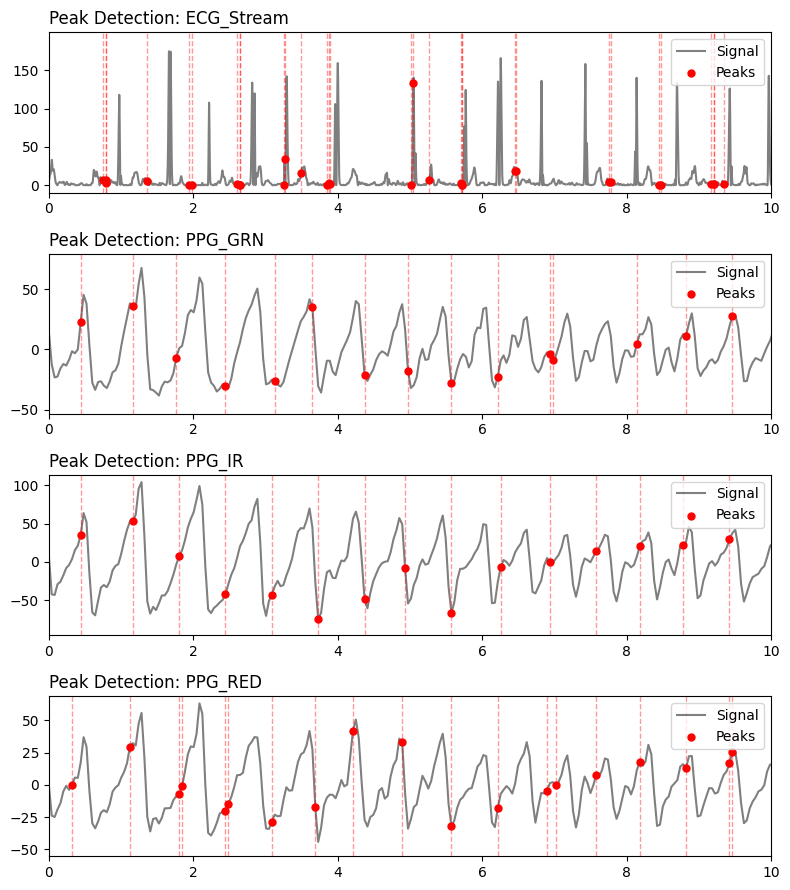

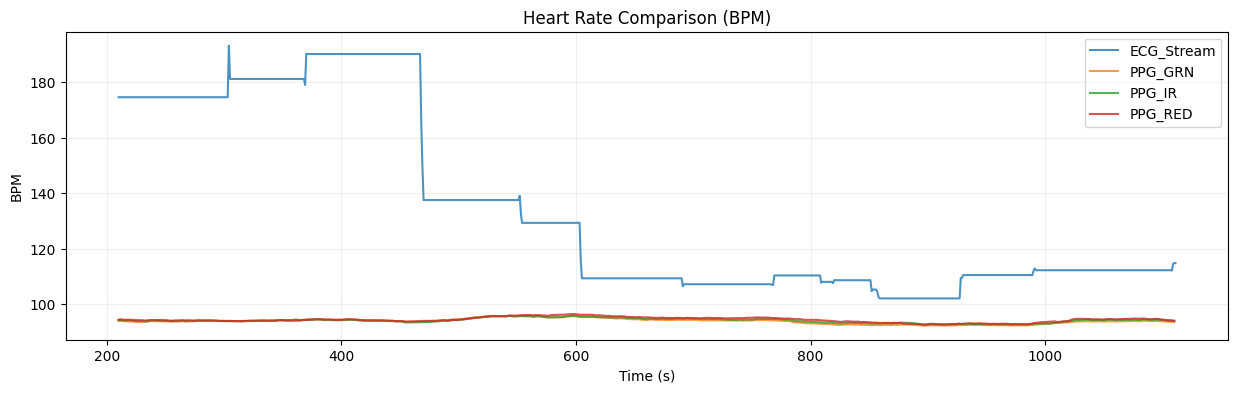

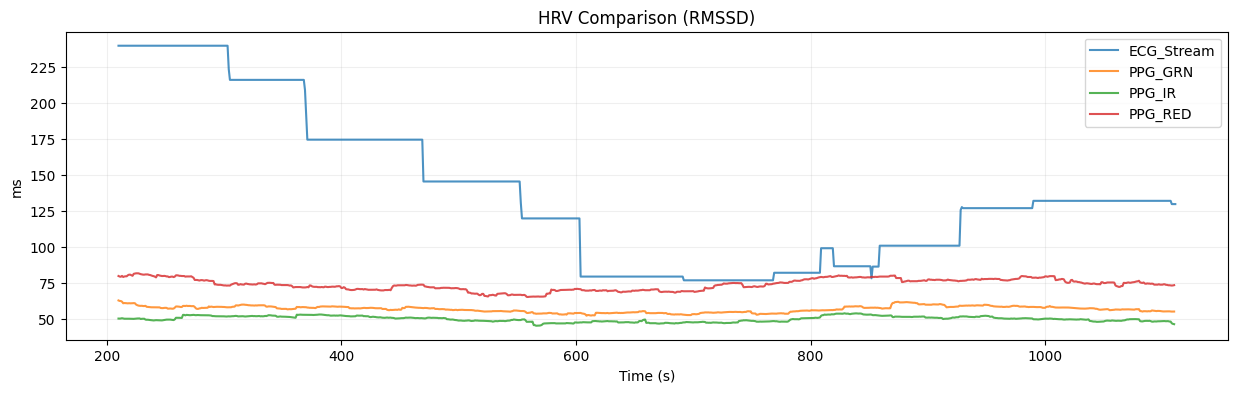

In [10]:
import numpy as np
import heartpy as hp
import neurokit2 as nk
import matplotlib.pyplot as plt

start = 60
end = 60 * 21

all_rmssd = {}
all_bpm = {}
all_t_vals = {}

# Setup for the 4x1 Peak Grid
fig_peaks, axes_peaks = plt.subplots(4, 1, figsize=(8, 9), sharex=False)
peak_plot_idx = 0

global_cleaned = None

for stream in streams:
    name = stream['info']['name'][0]
    data = np.array(stream['time_series']).flatten()
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]
    fs = estimate_fs(timestamps)
    
    mask = (start <= timestamps) & (timestamps <= end)
    segment_raw = data[mask]
    
    # Pre-processing
    if "ECG" in name:
        # Your specific voltage scaling
        segment_raw = (((segment_raw / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
        cleaned = nk.ecg_clean(segment_raw, sampling_rate=fs)
        global_cleaned = cleaned
        cleaned = hp.filter_signal(segment_raw, cutoff=[0.75, 40], sample_rate=fs, 
                               order=3, filtertype='bandpass')
        cleaned = hp.enhance_peaks(cleaned, iterations=1)
    else:
        cleaned = hp.filter_signal(segment_raw, cutoff=[0.5, 8], sample_rate=fs, filtertype='bandpass')
    
    window_size = 60 * 5
    step_size = 1
    overlap = (window_size - step_size) / window_size

    # HeartPy Processing
    wd, m = hp.process_segmentwise(
        hrdata=cleaned, 
        sample_rate=fs, 
        segment_width=window_size, 
        segment_overlap=overlap,
        replace_outliers=True, 
        outlier_method='iqr',
        reject_segmentwise=True,
        mode='fast'
    )
    
    # Store results for trend plotting
    rmssd_vals = np.array(m['rmssd'])
    bpm_vals = np.array(m['bpm'])
    t_vals = [(i * step_size) + start + (window_size / 2) for i in range(len(rmssd_vals))]
    
    all_rmssd[name] = rmssd_vals
    all_bpm[name] = bpm_vals
    all_t_vals[name] = t_vals

    # --- Fill 4x1 Grid ---
    if peak_plot_idx < 4:
        ax = axes_peaks[peak_plot_idx]
        # Use a segment from the middle for inspection
        sample_seg_idx = len(wd['peaklist']) // 2 
        
        # Calculate window indices
        s_start = int(sample_seg_idx * step_size * fs)
        s_end = s_start + int(window_size * fs)
        display_data = cleaned[s_start:s_end]
        time_x = np.linspace(0, window_size, len(display_data))
        
        ax.plot(time_x, display_data, color='black', alpha=0.5, label='Signal')
        
        # Detected Peaks
        peak_indices = wd['peaklist'][sample_seg_idx]
        valid_peaks = [p for p in peak_indices if p < len(display_data)]
        
        # Add Vertical Lines and Scatter points
        for p in valid_peaks:
            ax.axvline(x=p/fs, color='red', linestyle='--', alpha=0.4, linewidth=1)
        
        ax.scatter(np.array(valid_peaks)/fs, display_data[valid_peaks], color='red', s=25, zorder=3, label='Peaks')
        
        ax.set_title(f"Peak Detection: {name}", fontsize=12, loc='left')
        ax.set_xlim(0, 10) # Zoom into first 10 seconds of the window
        ax.legend(loc='upper right')
        peak_plot_idx += 1

fig_peaks.tight_layout()
plt.show()

# --- Comparative Trend Plots ---

# 1. All Heart Rates
plt.figure(figsize=(15, 4))
for name in all_bpm:
    plt.plot(all_t_vals[name], all_bpm[name], label=name, alpha=0.8)
plt.title("Heart Rate Comparison (BPM)")
plt.ylabel("BPM")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# 2. All RMSSD
plt.figure(figsize=(15, 4))
for name in all_rmssd:
    plt.plot(all_t_vals[name], all_rmssd[name], label=name, alpha=0.8)
plt.title("HRV Comparison (RMSSD)")
plt.ylabel("ms")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

HRV_MeanNN: 651.5351835858505
HRV_SDNN: 117.4051881289997
HRV_SDANN1: 23.967645205100503
HRV_SDNNI1: 112.18678106162983
HRV_SDANN2: 13.922534509075014
HRV_SDNNI2: 115.56561785701301
HRV_SDANN5: 10.956501027204698
HRV_SDNNI5: 116.73859084782441
HRV_RMSSD: 156.40039814837698
HRV_SDSD: 156.44291162639544
HRV_CVNN: 0.18019777148923474
HRV_CVSD: 0.24004904430117954
HRV_MedianNN: 650.3267973856209
HRV_MadNN: 106.59215686274501
HRV_MCVNN: 0.16390552763819083
HRV_IQRNN: 143.79084967320262
HRV_SDRMSSD: 0.750670647382991
HRV_Prc20NN: 558.1699346405229
HRV_Prc80NN: 736.9281045751634
HRV_pNN50: 68.24361065796629
HRV_pNN20: 83.46927678085916
HRV_MinNN: 302.2875816993464
HRV_MaxNN: 1269.6078431372548
HRV_HTI: 27.863636363636363
HRV_TINN: 484.375
HRV_ULF: nan
HRV_VLF: 0.01447923796145903
HRV_LF: 0.028420696145461784
HRV_HF: 0.03785223640278553
HRV_VHF: 0.00910694606054967
HRV_TP: 0.08985911657025601
HRV_LFHF: 0.7508326811403491
HRV_LFn: 0.31628060936077834
HRV_HFn: 0.4212398012303059
HRV_LnHF: -3.274

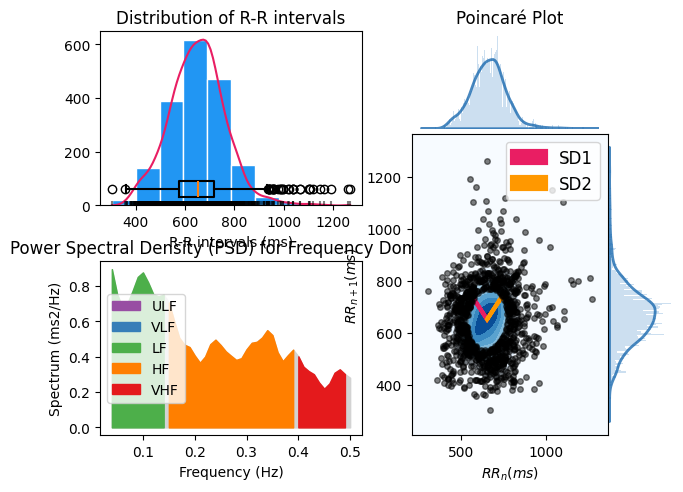

In [11]:
import pandas as pd

# Define your storage list
segment_results = []

cleaned = global_cleaned

np.trapezoid = np.trapz

new_peaks, info = nk.ecg_peaks(global_cleaned, sampling_rate=612, correct_artifacts=True)

# Compute HRV indices
hrv_indices = nk.hrv(new_peaks, sampling_rate=612, show=True)
for idx, row in hrv_indices.iterrows():
    for col in hrv_indices.columns:
        print(f"{col}: {row[col]}")

In [7]:
import neurokit2 as nk

local_start = 60
local_end = 60*21

stream = streams[0]
name = stream['info']['name'][0]
timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]
data = np.array(stream['time_series'])
data = (((data / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000 # convert to mV
fs = estimate_fs(timestamps)
mask = (local_start <= timestamps) & (timestamps <= local_end)
timestamps = timestamps[mask]
timestamps = timestamps - timestamps[0]
data = data[mask]

local_start_2 = 4*60+20
local_end_2 = 5*60+20

cleaned = nk.ecg_clean(data, sampling_rate=fs, method="neurokit")

physiozoo_indices = np.array(extract_physiozoo_indices("physiozoo_ecg_peaks.txt")).flatten()
physiozoo_peaks = physiozoo_indices / fs

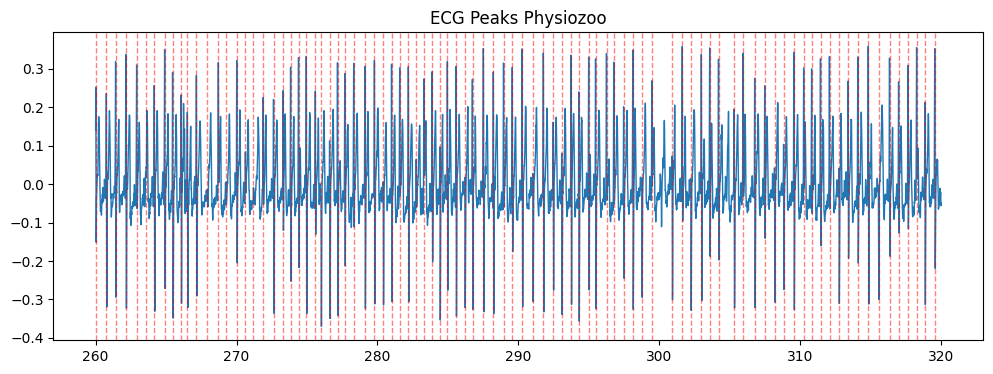

Percent data removed: 0.2666666666666667


In [81]:
plt.figure(figsize=(12, 4))
local_mask = (local_start_2 <= timestamps) & (timestamps <= local_end_2)
plt.plot(timestamps[local_mask], cleaned[local_mask], linewidth=1)
filtered_peaks = []
for t in physiozoo_peaks:
    if t >= local_start_2 and t <= local_end_2:
        filtered_peaks.append(t)
        plt.axvline(x=t, color='r', linestyle='--', alpha=0.5, linewidth=1)
plt.title(f"ECG Peaks Physiozoo")
plt.show()

pz_rr = quotient_filter(filtered_peaks, ratio=0.2)


In [14]:
import numpy as np
import neurokit2 as nk
from scipy.stats import spearmanr

# NeuroKit detection methods to test
methods = [
    "neurokit",
    "pantompkins1985",
    "nabian2018",
    "hamilton2002",
    "martinez2004",
    "christov2004",
    "gamboa2008",
    "elgendi2010",
    "engzeemod2012",
    "khamis2016",
    "kalidas2017",
    "rodrigues2021",
    "emrich2023",
    "promac"
]

tolerance = 0.03  # 20 ms
results = {}

for method in methods:
    try:
        # --- Run peak detection ---
        _, info = nk.ecg_peaks(cleaned, sampling_rate=fs, method=method)
        detected_indices = info["ECG_R_Peaks"]
        detected_peaks = detected_indices / fs

        # --- Peak matching ---
        tp = 0
        fp = 0
        timing_errors = []

        used_ref = np.zeros(len(physiozoo_peaks), dtype=bool)

        matched_ref = []
        matched_det = []

        for d in detected_peaks:
            diffs = np.abs(physiozoo_peaks - d)
            min_idx = np.argmin(diffs)

            if diffs[min_idx] <= tolerance and not used_ref[min_idx]:
                tp += 1
                used_ref[min_idx] = True
                timing_errors.append(d - physiozoo_peaks[min_idx])

                matched_ref.append(physiozoo_peaks[min_idx])
                matched_det.append(d)
            else:
                fp += 1

        fn = np.sum(~used_ref)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        f1 = (
            2 * sensitivity * ppv / (sensitivity + ppv)
            if (sensitivity + ppv) > 0 else np.nan
        )

        timing_errors = np.array(timing_errors)

        # --- RR interval comparison (MATCHED ONLY) ---
        matched_ref = np.array(matched_ref)
        matched_det = np.array(matched_det)

        if len(matched_ref) > 3:
            # Ensure time ordering
            order = np.argsort(matched_ref)
            matched_ref = matched_ref[order]
            matched_det = matched_det[order]

            rr_ref = np.diff(matched_ref)
            rr_det = np.diff(matched_det)

            rr_corr, _ = spearmanr(rr_ref, rr_det)
        else:
            rr_corr = np.nan

        results[method] = {
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "Sensitivity": sensitivity,
            "PPV": ppv,
            "F1": f1,
            "Timing MAE (ms)": np.mean(np.abs(timing_errors)) * 1000
                if len(timing_errors) else np.nan,
            "Timing STD (ms)": np.std(timing_errors) * 1000
                if len(timing_errors) else np.nan,
            "RR Spearman r": rr_corr
        }

    except Exception as e:
        results[method] = {"error": str(e)}

# --- Print results ---
for method, metrics in results.items():
    print(f"\n=== {method} ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")


['zong error: `pad_width` must be of integral type.']

=== neurokit ===
TP: 1682
FP: 130
FN: 180
Sensitivity: 0.9033297529538131
PPV: 0.9282560706401766
F1: 0.9156232988568317
Timing MAE (ms): 6.255069051151619
Timing STD (ms): 4.749297916270413
RR Spearman r: 0.998132762294812

=== pantompkins1985 ===
TP: 806
FP: 930
FN: 1056
Sensitivity: 0.43286788399570353
PPV: 0.4642857142857143
F1: 0.4480266814897165
Timing MAE (ms): 15.20292173346583
Timing STD (ms): 14.976721542850067
RR Spearman r: 0.9974259338328381

=== nabian2018 ===
TP: 1275
FP: 425
FN: 587
Sensitivity: 0.6847475832438239
PPV: 0.75
F1: 0.7158899494665919
Timing MAE (ms): 6.492976867137294
Timing STD (ms): 3.3727495521629987
RR Spearman r: 0.9994827554569102

=== hamilton2002 ===
TP: 779
FP: 896
FN: 1083
Sensitivity: 0.41836734693877553
PPV: 0.46507462686567164
F1: 0.4404862878145321
Timing MAE (ms): 21.527048722818133
Timing STD (ms): 11.498042893120783
RR Spearman r: 0.9989305986607385

=== martinez2004 ===
TP: 1316
FP: 16

In [15]:
import numpy as np
import neurokit2 as nk
import heartpy as hp
from scipy.stats import spearmanr
from heartpy.datautils import rolling_mean

tolerance = 0.05  # 20 ms
results = {}

try:
    # --- Run peak detection ---
    rol_mean = rolling_mean(cleaned, windowsize = 1.5, sample_rate = fs)
    wd = hp.peakdetection.detect_peaks(cleaned, rol_mean, ma_perc = 20, sample_rate = fs)
    detected_indices = wd["peaklist"]
    detected_peaks = detected_indices / fs
    print(detected_peaks)

    # --- Peak matching ---
    tp = 0
    fp = 0
    timing_errors = []

    used_ref = np.zeros(len(physiozoo_peaks), dtype=bool)

    matched_ref = []
    matched_det = []

    for d in detected_peaks:
        diffs = np.abs(physiozoo_peaks - d)
        min_idx = np.argmin(diffs)

        if diffs[min_idx] <= tolerance and not used_ref[min_idx]:
            tp += 1
            used_ref[min_idx] = True
            timing_errors.append(d - physiozoo_peaks[min_idx])

            matched_ref.append(physiozoo_peaks[min_idx])
            matched_det.append(d)
        else:
            fp += 1

    fn = np.sum(~used_ref)

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    f1 = (
        2 * sensitivity * ppv / (sensitivity + ppv)
        if (sensitivity + ppv) > 0 else np.nan
    )

    timing_errors = np.array(timing_errors)

    # --- RR interval comparison (MATCHED ONLY) ---
    matched_ref = np.array(matched_ref)
    matched_det = np.array(matched_det)

    if len(matched_ref) > 3:
        # Ensure time ordering
        order = np.argsort(matched_ref)
        matched_ref = matched_ref[order]
        matched_det = matched_det[order]

        rr_ref = np.diff(matched_ref)
        rr_det = np.diff(matched_det)

        rr_corr, _ = spearmanr(rr_ref, rr_det)
    else:
        rr_corr = np.nan

    results[method] = {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Sensitivity": sensitivity,
        "PPV": ppv,
        "F1": f1,
        "Timing MAE (ms)": np.mean(np.abs(timing_errors)) * 1000
            if len(timing_errors) else np.nan,
        "Timing STD (ms)": np.std(timing_errors) * 1000
            if len(timing_errors) else np.nan,
        "RR Spearman r": rr_corr
    }

except Exception as e:
    results[method] = {"error": str(e)}

# --- Print results ---
for method, metrics in results.items():
    print(f"\n=== {method} ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")


[2.56610394e-01 6.17826298e-01 7.50217648e-01 ... 1.19952937e+03
 1.19987588e+03 1.19998375e+03]

=== promac ===
TP: 1672
FP: 3334
FN: 190
Sensitivity: 0.8979591836734694
PPV: 0.3339992009588494
F1: 0.48689574839836924
Timing MAE (ms): 6.344289822185314
Timing STD (ms): 5.937111393660152
RR Spearman r: 0.9974739731768515


In [10]:
_, info = nk.ecg_peaks(cleaned, sampling_rate=fs)
detected_indices = info["ECG_R_Peaks"]
detected_peaks = detected_indices / fs

def quotient_filter(peak_times=None, rr=None, ratio = 0.2):
    
    if peak_times is not None:
        rr = np.diff(peak_times)
    
    rr_mean = np.mean(rr)
    rr_std = np.std(rr)
    new_rr = []

    # Keep the first RR by default
    if len(rr) > 0:
        new_rr.append(rr[0])

    ratio_check = lambda i: abs(rr[i] - rr[i-1]) / rr[i-1] <= ratio
    std_check = lambda i, s: rr_mean - rr_std * s <= rr[i] <= rr_mean + rr_std * s
    for i in range(1, len(rr)-1):
        # Compare successive RR intervals
        if ratio_check(i):
            new_rr.append(rr[i])
        else:
            pass
        
    new_rr.append(rr[-1])

    print("Percent data removed:", 1-len(new_rr)/len(rr))
    return np.array(new_rr) * 1000

196.24062268879783


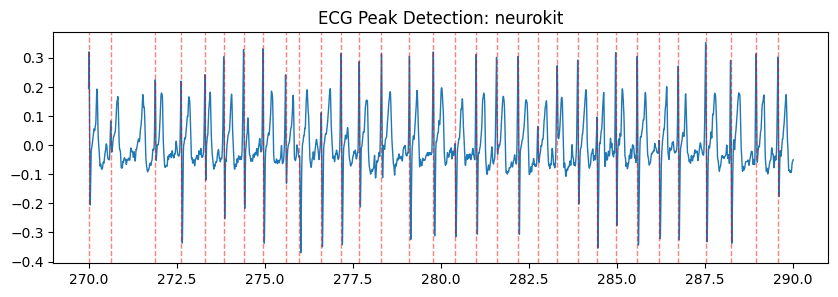

271.0103943911216


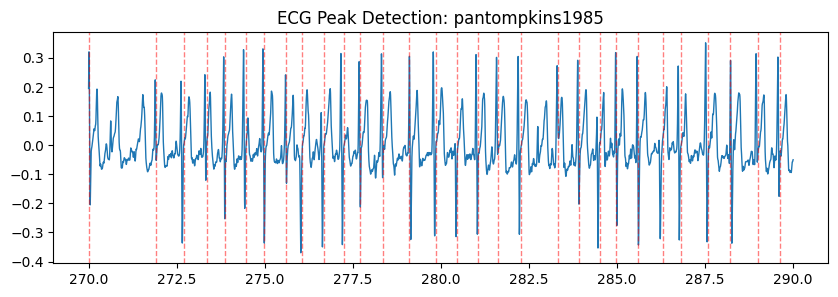

286.24319919064635


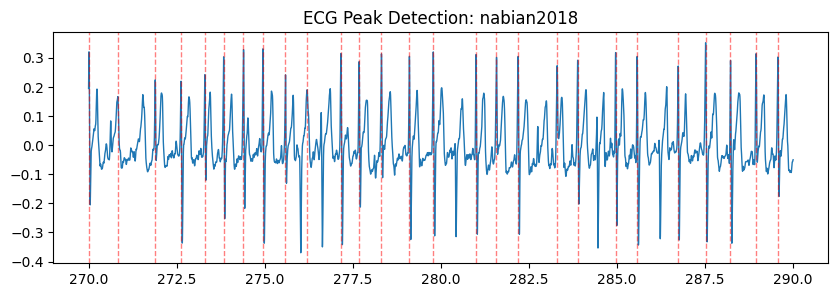

303.96676588143123


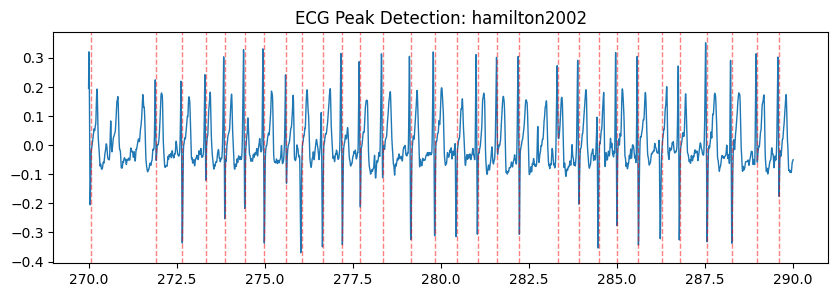

627.3317361983325


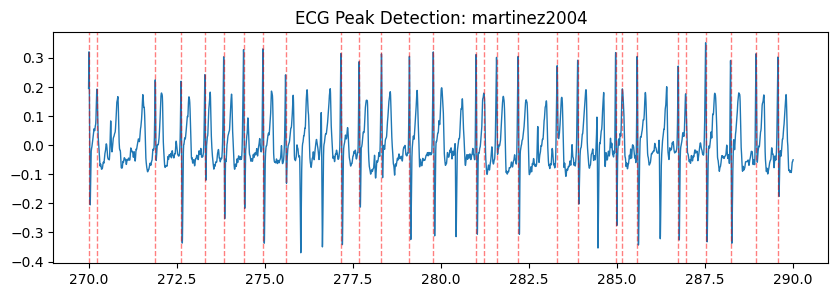

38.7895839922358


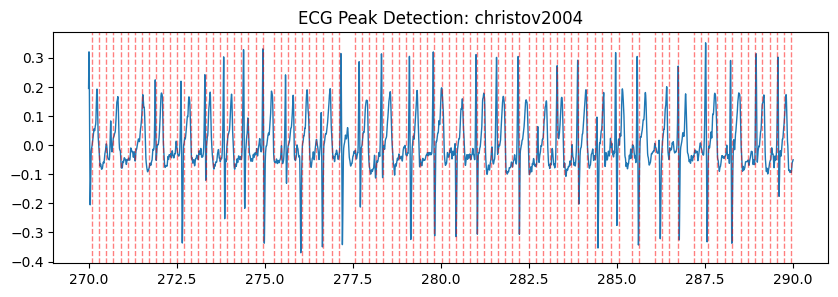

223.8629187680669


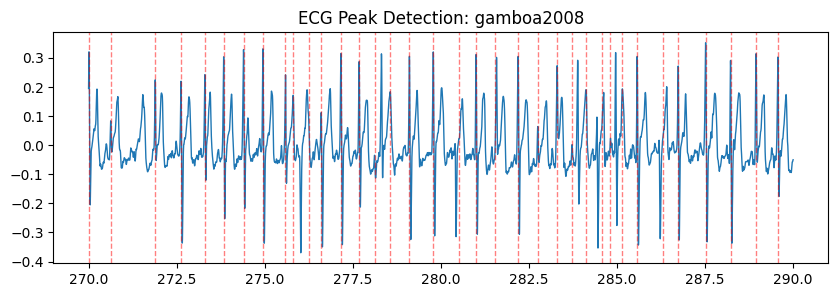

227.56723363000248


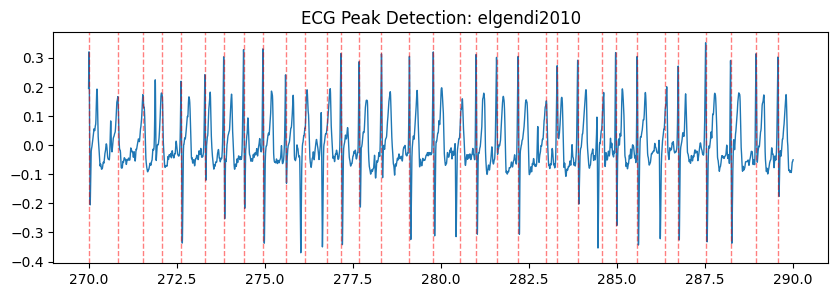

476.39973268434306


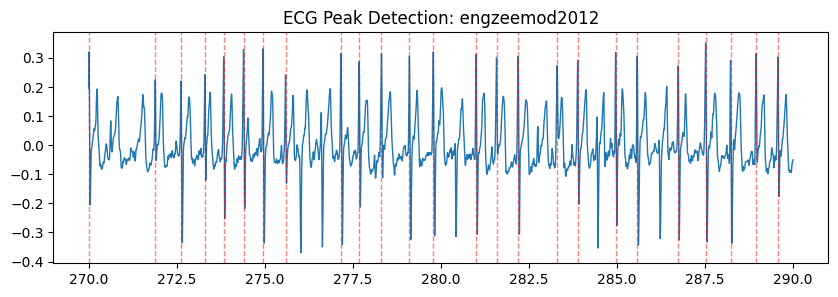

Method khamis2016 failed: expected a sequence of integers or a single integer, got '735410.585818688'
268.90138618818713


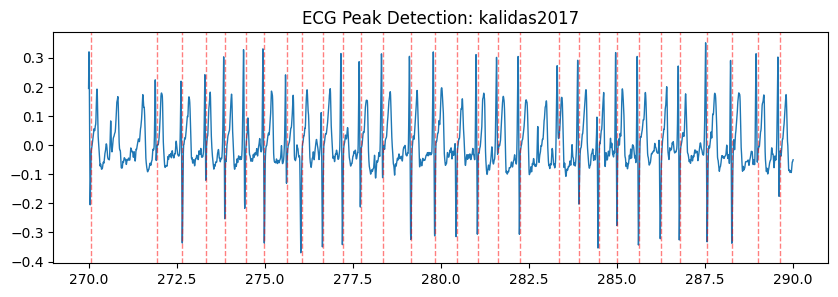

239.91025961195865


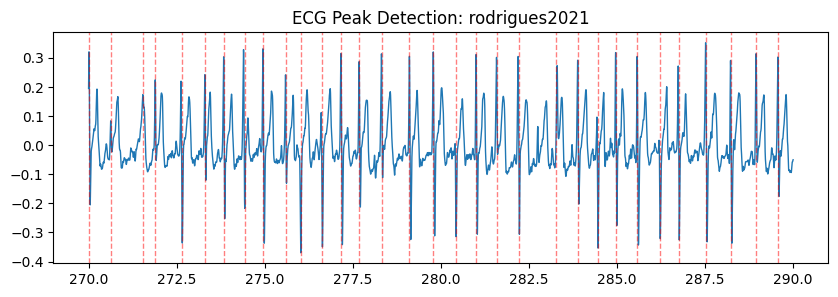

Method emrich2023 failed: slice indices must be integers or None or have an __index__ method
['zong error: `pad_width` must be of integral type.']
209.75045384099005


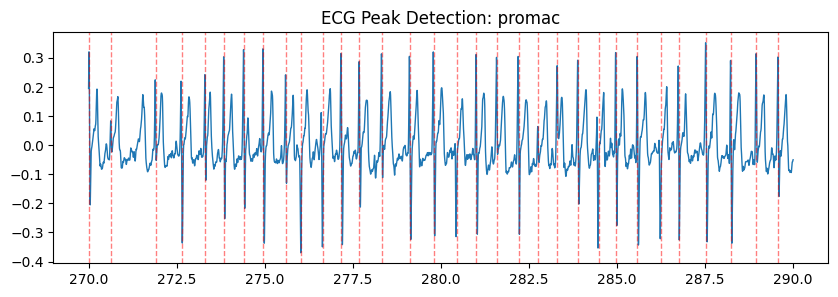

In [17]:
nk_detection_types = methods

"""[
    "neurokit",
    "pantompkins1985",
    "nabian2018",
    "hamilton2002",
    "martinez2004",
    "christov2004",
    "gamboa2008",
    "elgendi2010",
    "engzeemod2012",
    "khamis2016",
    "kalidas2017",
    "rodrigues2021",
    "emrich2023",
    "promac"
]"""

for detect_method in nk_detection_types:
    try:
        peaklist = nk.ecg_peaks(cleaned, sampling_rate=estimate_fs(timestamps), method=detect_method)[0].to_numpy().flatten()
        plt.figure(figsize=(10, 3))
        mask = (local_start_2 <= timestamps) & (timestamps <= local_end_2)
        plt.plot(timestamps[mask], cleaned[mask], linewidth=1)
        hrv_indices = nk.hrv_time(peaklist, sampling_rate=estimate_fs(timestamps), show=False)
        rmssd = hrv_indices["HRV_RMSSD"].values[0]
        print(rmssd)
        for i in range(len(peaklist)):
            if peaklist[i] and local_start_2 <= timestamps[i] <= local_end_2:
                plt.axvline(x=timestamps[i], color='r', linestyle='--', alpha=0.5, linewidth=1)
        plt.title(f"ECG Peak Detection: {detect_method}")
        plt.show()
    except Exception as e:
        print(f"Method {detect_method} failed: {e}")

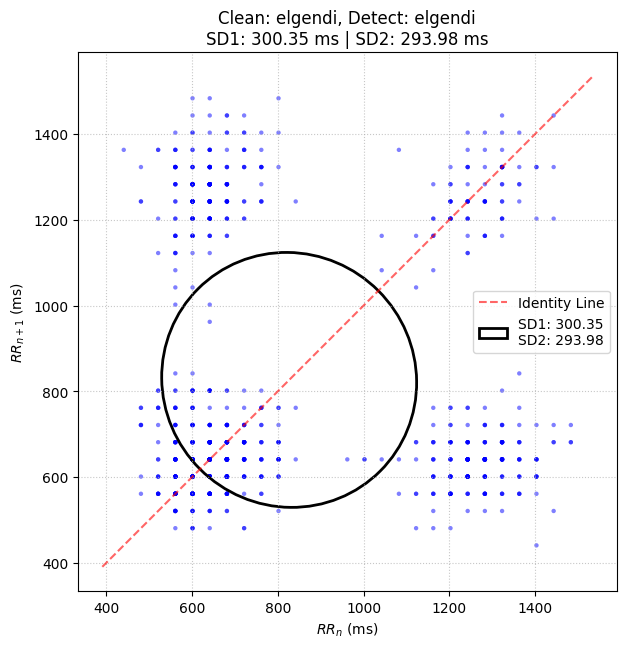

Clean: elgendi, Detect: elgendi, RMSSD: 988.497 ms, BPM: 55.840
SD1/SD2 ratio = 1.022


In [18]:
nk_cleaning_types = [
    "neurokit", "biosppy", "pantompkins1985", "hamilton2002", 
    "elgendi2010", "engzeemod2012", "vg", "templateconvolution"
]

nk_detection_types = [
    "neurokit",
    "pantompkins1985",
    "nabian2018",
    "hamilton2002",
    "martinez2004",
    "christov2004",
    "gamboa2008",
    "elgendi2010",
    "engzeemod2012",
    "khamis2016",
    "kalidas2017",
    "rodrigues2021",
    "emrich2023",
    "promac"
]

nk_ppg_detection_types = [
    "elgendi", "bishop", "charlton"
]

nk_ppg_cleaning_types = [
    "elgendi", "nabian2018"
]

stream = streams[1] # ECG
data = np.array(stream['time_series'])
timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]
mask = (60 <= timestamps) & (timestamps <= 60*21)
timestamps = timestamps[mask]
data = data[mask]

"""
data = nk.ppg_simulate(duration=60*22, sampling_rate=612, heart_rate=90)
timestamps = np.linspace(0, 60*22, len(data))
mask = (60 <= timestamps) & (timestamps <= 60*21)
timestamps = timestamps[mask]
data = data[mask]
"""

for clean_method in nk_ppg_cleaning_types:
    for detect_method in nk_ppg_detection_types:
        if not (clean_method == "elgendi" and detect_method == "elgendi"):
            continue
        try:
            cleaned = nk.ppg_clean(data, sampling_rate=estimate_fs(timestamps), method=clean_method)
            peaks_df, info = nk.ppg_peaks(cleaned, sampling_rate=estimate_fs(timestamps), method=detect_method)
            peak_times = timestamps[info["PPG_Peaks"]]
            rr_ms = np.diff(peak_times) * 1000
            
            drr_ms = np.diff(rr_ms)
            drr_sq_ms2 = drr_ms ** 2

            wd, m = hp.analysis.calc_ts_measures(rr_ms, drr_ms, drr_sq_ms2)
            
            sd1, sd2 = plot_poincare(np.array(peak_times), f"Clean: {clean_method}, Detect: {detect_method}")
            print(f"Clean: {clean_method}, Detect: {detect_method}, RMSSD: {m['rmssd']:.3f} ms, BPM: {m['bpm']:.3f}")
            print(f"SD1/SD2 ratio = {sd1/sd2:.3f}")
        except Exception as e:
            print(f"Failed for Clean: {clean_method}, Detect: {detect_method} with error: {e}")

In [90]:
import time
import tkinter as tk

# Store timestamps here
timestamps = []

# High-resolution start time
t0 = time.perf_counter()

def log_timestamp():
    t = time.perf_counter() - t0
    timestamps.append(t)
    print(f"Recorded: {t:.9f} s")

def on_close():
    print("\nFinal timestamps:")
    print(timestamps)
    root.destroy()

# GUI setup
root = tk.Tk()
root.title("Timestamp Logger")

button = tk.Button(
    root,
    text="Click to record timestamp",
    command=log_timestamp,
    font=("Arial", 14),
    padx=20,
    pady=10
)
button.pack(padx=20, pady=20)

root.protocol("WM_DELETE_WINDOW", on_close)

root.mainloop()

timestamps = np.array(timestamps)
timestamps -= timestamps[0]
diffs = np.diff(np.diff(timestamps))
squared_diffs = diffs**2
mean_squared_diffs = np.mean(squared_diffs)
rmssd = np.sqrt(mean_squared_diffs) * 1000
rmssd

Recorded: 12.892749600 s
Recorded: 14.127100400 s
Recorded: 15.263795100 s
Recorded: 16.311575400 s
Recorded: 17.423948700 s
Recorded: 18.277763400 s
Recorded: 19.353523800 s
Recorded: 20.306287300 s
Recorded: 21.291303100 s
Recorded: 22.318522100 s
Recorded: 23.485535800 s
Recorded: 24.511005800 s
Recorded: 25.571892600 s
Recorded: 26.668176500 s
Recorded: 27.702339700 s
Recorded: 28.741923200 s
Recorded: 29.736286200 s
Recorded: 30.749197300 s
Recorded: 31.743230000 s
Recorded: 32.840593400 s
Recorded: 33.934551400 s
Recorded: 35.060162900 s
Recorded: 36.091921900 s
Recorded: 37.154128400 s
Recorded: 38.099274000 s
Recorded: 39.100677600 s
Recorded: 40.038165100 s
Recorded: 40.989292500 s
Recorded: 41.989973000 s
Recorded: 42.867505200 s
Recorded: 43.770235100 s
Recorded: 44.722349500 s
Recorded: 45.707813400 s
Recorded: 46.852243800 s
Recorded: 47.886969500 s
Recorded: 48.962913200 s
Recorded: 50.024684600 s
Recorded: 50.940039700 s
Recorded: 51.929205100 s
Recorded: 52.880637400 s


80.77781115472297

[0.73223858 0.59494384 0.59984723 ... 0.67830136 0.81396163 0.72243181]
Overall RMSSD: 147.37 ms
Percent data removed: 0.2222222222222222
Percent data removed: 0.4509803921568627
Percent data removed: 0.4693877551020408
Percent data removed: 0.19318181818181823
Percent data removed: 0.22988505747126442
Percent data removed: 0.28888888888888886
Percent data removed: 0.3846153846153846
Percent data removed: 0.25555555555555554
Percent data removed: 0.36170212765957444
Percent data removed: 0.36458333333333337
Percent data removed: 0.2680412371134021
Percent data removed: 0.19791666666666663
Percent data removed: 0.31182795698924726
Percent data removed: 0.25555555555555554
Percent data removed: 0.3932584269662921
Percent data removed: 0.19318181818181823
Percent data removed: 0.3548387096774194
Percent data removed: 0.4639175257731959
Percent data removed: 0.3932584269662921
Percent data removed: 0.22093023255813948
Percent data removed: 0.3586956521739131
Percent data removed: 0.3939393

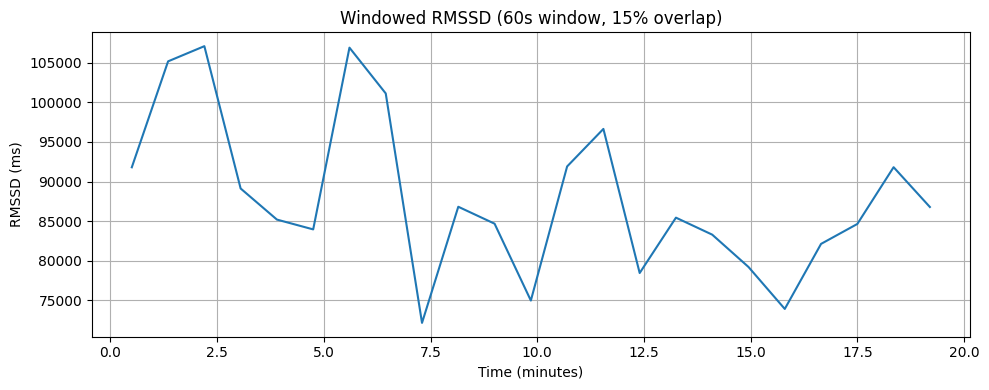

In [11]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Parameters
# ------------------------
fs = 612
duration_sec = 10 * 60  # 10 minutes

window_sec = 60
overlap_ratio = 0.15
step_sec = window_sec * (1 - overlap_ratio)

"""
# ------------------------
# Simulate ECG
# ------------------------
ecg = nk.ecg_simulate(
    duration=duration_sec,
    sampling_rate=fs,
    heart_rate=90,
    heart_rate_std=20  # adds realistic HRV
)

# ------------------------
# Clean + detect peaks
# ------------------------
cleaned = nk.ecg_clean(ecg, sampling_rate=fs)
signals, info = nk.ecg_peaks(cleaned, sampling_rate=fs, correct_artifacts=True)
"""

# ------------------------
# RR intervals (seconds)
# ------------------------
peak_times = physiozoo_peaks
rr = np.diff(peak_times)
print(rr)

# ------------------------
# Overall RMSSD
# ------------------------
drr = np.diff(rr)
overall_rmssd = np.sqrt(np.mean(drr ** 2)) * 1000

print(f"Overall RMSSD: {overall_rmssd:.2f} ms")

# ------------------------
# Windowed RMSSD
# ------------------------
windowed_rmssd = []
window_centers = []

start = peak_times[0]
end = peak_times[-1]

t = start
while t + window_sec <= end:
    w_start = t
    w_end = t + window_sec

    # RR intervals fully inside window
    mask = (peak_times[:-1] >= w_start) & (peak_times[1:] <= w_end)
    rr_w = quotient_filter(rr=rr[mask], ratio=0.2)

    if len(rr_w) >= 3:
        drr_w = np.diff(rr_w)
        rmssd_w = np.sqrt(np.mean(drr_w ** 2)) * 1000
        windowed_rmssd.append(rmssd_w)
        window_centers.append(w_start + window_sec / 2)

    t += step_sec

windowed_rmssd = np.array(windowed_rmssd)
window_centers = np.array(window_centers)

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10, 4))
plt.plot(window_centers / 60, windowed_rmssd)
plt.xlabel("Time (minutes)")
plt.ylabel("RMSSD (ms)")
plt.title("Windowed RMSSD (60s window, 15% overlap)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
bpm = 60/np.diff(np.array(physiozoo_peaks))
print(bpm)

print(np.mean(bpm))
print(np.std(bpm))

[ 81.9405068  100.84985452 100.02546879 ...  88.45625794  73.71354828
  83.05282137]
96.19071777371553
19.324671453898617
